# Mandatory Assignment 1

#### Part I: Multi-layer Perceptron

***

Please see the description of the assignment in the README file (section 1) <br>
**Guide notebook**: [material/nns_pytorch.ipynb](material/nns_pytorch.ipynb)

Table of contents:
1. Activate GPU
2. Load data
3. Inspect data
4. Artificial neural network (**Where you will implement the ANN**)
5. Training hyperparameters (**Where you will add training parameters**)
6. Training
7. Plot loss and accuracy
8. Evaluate


In [ ]:
# auxilary imports
import random
import matplotlib.pyplot as plt
import os
from pathlib import Path

# pytorch
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F  # noqa
import torch.cuda
print(f'CUDA available? : {torch.cuda.is_available()}')
#https://github.com/vosen/ZLUDA/tree/master

CUDA available? : False


First, a bit of a hack in case your IDE wants to run the notebook from /`assignment/` and not the project root folder `/ma1`. We need the working directory to be `/ma1` for local imports to work.

In [3]:
# Ensure the working directory is set to the "ma1" folder.
while Path.cwd().name != "ma1" and "ma1" in str(Path.cwd()):
    os.chdir("..")  # Move up one directory
print(f"Working directory set to: {Path.cwd()}")

Working directory set to: c:\Users\wwwkr\aiml25\mas\ma1


##### Import local files

To declutter the notebooks, your are given a module (`/src`) of useful functions. Please study each one as they contain important code (particularly `src.training` and `src.evaluation`). 

In [5]:
# local files
from src.utils import get_device
from src.data import load_torch_data, to_dataloader, train_val_split
from src.training import fit
from src.evaluation import evaluate
from src.visualize import plot_training_history

### 1. Activate GPU
If available. Note that this is not necessary, but it will speed up your training.

In [6]:
# Device will determine whether to run the training on GPU or CPU.
DEVICE = get_device()

Running pytorch version (2.5.1) with backend = cpu


### 2. Load data

In [ ]:
# load the training/validation data *(it is in data.py)
train_val = load_torch_data(
    dataset="MNIST",
    root = 'data',                     # The root directory where the dataset will be stored
    download = True,                   # If the dataset is not found at root, it will be downloaded
    train = True,                      # The train dataset (as opposed to the test dataset)
    transform = transforms.ToTensor()  # transformations to be applied to the dataset (only cast to tensor)
)

# load the testing data
test = load_torch_data(
    dataset = "MNIST",
    root = 'data',
    download = True,
    train = False,
    transform = transforms.ToTensor()
)

f"{len(train_val)=}, {len(test)=}"

'len(train_val)=60000, len(test)=10000'

In [8]:
# split training data in training and validation (just like train_test_split in sklearn)
train, val = train_val_split(train_val, val_ratio=0.2, seed=42)

f"{len(val)=}, {len(train)=}"

'len(val)=12000, len(train)=48000'

In [ ]:
# create dataloders for easy batch loading during training

train_loader = to_dataloader(train, batch_size = 64, shuffle = True) #load 64 images at a time, shuffle the data
val_loader = to_dataloader(val, batch_size = 64, shuffle = False)
test_loader = to_dataloader(test, batch_size = 64, shuffle = False)

### 3. Inspect data

Default image shape: torch.Size([1, 28, 28])
Reshaped image shape: torch.Size([28, 28])
Total pixels: 784
The label for this image: 2


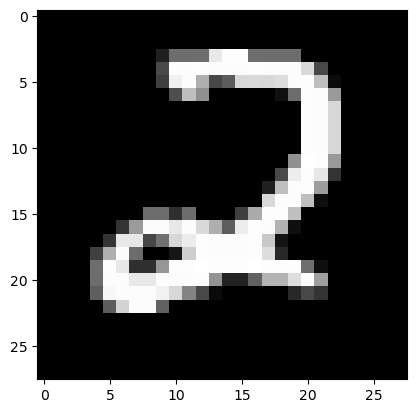

In [ ]:
# Pick a random example from the training set
selection = random.randrange(len(train)-1)
image, label = train[selection]

# Plot the image
print(f"Default image shape: {image.shape}")
image = image.view([28,28])

print(f"Reshaped image shape: {image.shape}")
plt.imshow(image, cmap="gray")

print(f"Total pixels: {image.shape[0] * image.shape[1]}")

# Print the label
print(f"The label for this image: {label}")
# for now it is black and white so we have only 1 channel, but we will need to change it to 3 channels for the model next week



***

### 4. Artificial neural network

In [ ]:
class MLP(nn.Module):

  def __init__(self):
    super().__init__()

    # TODO: define layers
    # in the first layer in the nn I need 728 input features, so I need to flatten the image to 1D array
    self.fc1 = nn.Linear(784, 500) # 28 * 28 = 784
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.5) #prevent overfitting
    self.fc2 = nn.Linear(500, 10) # 10 classes beacuse we have 10 digits
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.5)
    self.fc3 = nn.Linear(500, 250) # Adding more hidden layers will enable the model to learn more complex patterns.

  
  def forward(self, x : torch.Tensor):

    # TODO: define forward pass
    x = self.relu(self.fc1(x)) 
    x = self.fc2(x)
    x = self.relu(self.fc3(x))

    return x

### 5. Training hyperparameters

In [25]:
LR = 0.01  # TODO: define the learning rate to define the step size for the optimizer to escape the local minima
NUM_EPOCHS = 30 # TODO: define the number of epochs (i.e. passes over the dataset to learn all the sygnals)
criterion = nn.CrossEntropyLoss()  # The loss function

Instantiate the model and optimizer

In [26]:
model = MLP().to(DEVICE)   # Create an instance of the MLP model and move it to device (GPU or CPU)
optimizer = torch.optim.SGD(model.parameters(), lr=LR) # The optimizer (here, SGD - you can also try ADAM)

In [27]:
model

MLP(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

### 6. Training

In [28]:
model, history = fit(
    model,
    train_loader = train_loader,
    val_loader = val_loader,
    device = DEVICE,
    optimizer = optimizer,
    criterion = criterion,
    num_epochs = NUM_EPOCHS
)

Epoch [1/30]: Train Loss: 1.3120 | Train Accuracy: 73.71% | Val Loss: 0.6794 | Val Accuracy: 84.67%
Epoch [2/30]: Train Loss: 0.5364 | Train Accuracy: 86.81% | Val Loss: 0.4661 | Val Accuracy: 87.82%
Epoch [3/30]: Train Loss: 0.4164 | Train Accuracy: 88.86% | Val Loss: 0.4025 | Val Accuracy: 88.93%
Epoch [4/30]: Train Loss: 0.3685 | Train Accuracy: 89.84% | Val Loss: 0.3682 | Val Accuracy: 89.62%
Epoch [5/30]: Train Loss: 0.3405 | Train Accuracy: 90.46% | Val Loss: 0.3466 | Val Accuracy: 89.98%
Epoch [6/30]: Train Loss: 0.3211 | Train Accuracy: 90.94% | Val Loss: 0.3315 | Val Accuracy: 90.48%
Epoch [7/30]: Train Loss: 0.3057 | Train Accuracy: 91.34% | Val Loss: 0.3175 | Val Accuracy: 91.06%
Epoch [8/30]: Train Loss: 0.2928 | Train Accuracy: 91.75% | Val Loss: 0.3077 | Val Accuracy: 91.32%
Epoch [9/30]: Train Loss: 0.2813 | Train Accuracy: 92.10% | Val Loss: 0.2994 | Val Accuracy: 91.50%
Epoch [10/30]: Train Loss: 0.2711 | Train Accuracy: 92.33% | Val Loss: 0.2879 | Val Accuracy: 91.79%

### 7. Plot loss and accuracy

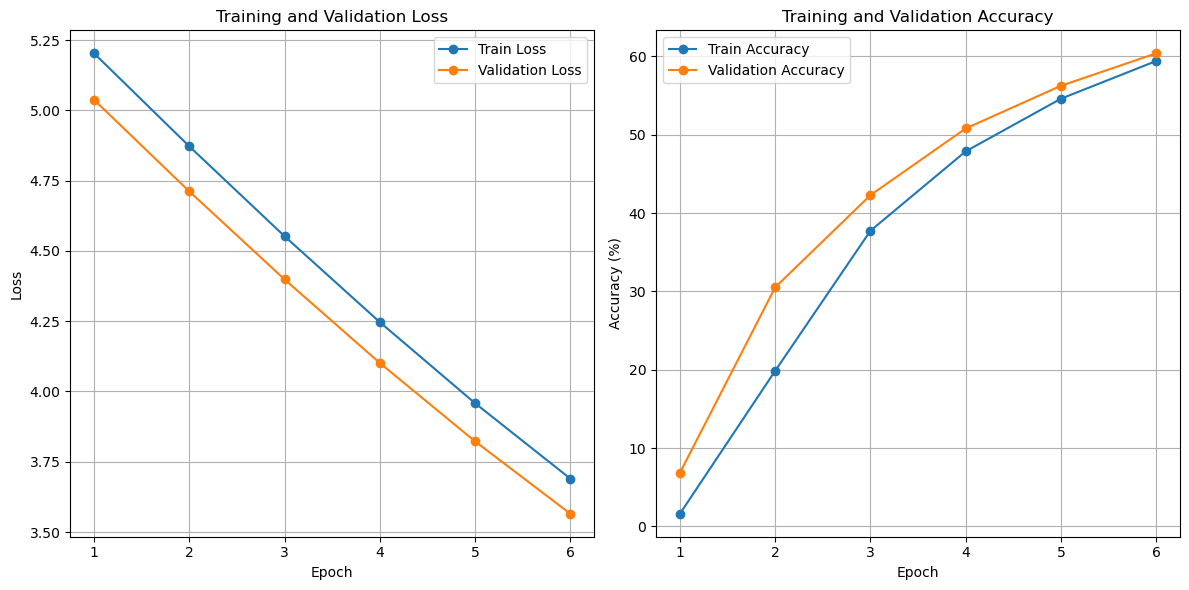

In [ ]:
# we want to see it flatten the loss curve and the accuracy curve
# train and val accuracy should be close to each other, if not, it is overfitting
plot_training_history(history)

### 8. Evaluate

In [ ]:
evaluate(
    model = model,
    data_loader = train_loader,  # evaluate on training data
    criterion = criterion,
    device = DEVICE,
)

In [ ]:
evaluate(
    model = model,
    data_loader = val_loader,  # evaluate on validation data
    criterion = criterion,
    device = DEVICE,
)

In [ ]:
evaluate(
    model = model,
    data_loader = test_loader,  # evaluate on testing data
    criterion = criterion,
    device = DEVICE,
)